In [1]:
# get the dataset from here: https://www.kaggle.com/datasets/iarunava/cell-images-for-detecting-malaria

In [3]:
import os
import fiftyone as fo

dataset_path = '/home/saiteja/Desktop/pruning/data/cell_images'


DATASET_DIR = os.path.join(dataset_path,"cell_images/")

In [4]:
# Create FiftyOne dataset
dataset = fo.Dataset.from_dir(
    DATASET_DIR,
    fo.types.ImageClassificationDirectoryTree,
    name="malaria-cell-images",
)
dataset.persistent = True

print(dataset)

 100% |█████████████| 27560/27560 [12.4s elapsed, 0s remaining, 2.7K samples/s]      
Name:        malaria-cell-images
Media type:  image
Num samples: 27560
Persistent:  True
Tags:        []
Sample fields:
    id:               fiftyone.core.fields.ObjectIdField
    filepath:         fiftyone.core.fields.StringField
    tags:             fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:         fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.ImageMetadata)
    created_at:       fiftyone.core.fields.DateTimeField
    last_modified_at: fiftyone.core.fields.DateTimeField
    ground_truth:     fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Classification)


In [5]:
import numpy as np
from fastai.data.all import *
from fastai.vision.data import *
from fastai.vision.all import *

/home/saiteja/anaconda3/envs/fastai_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


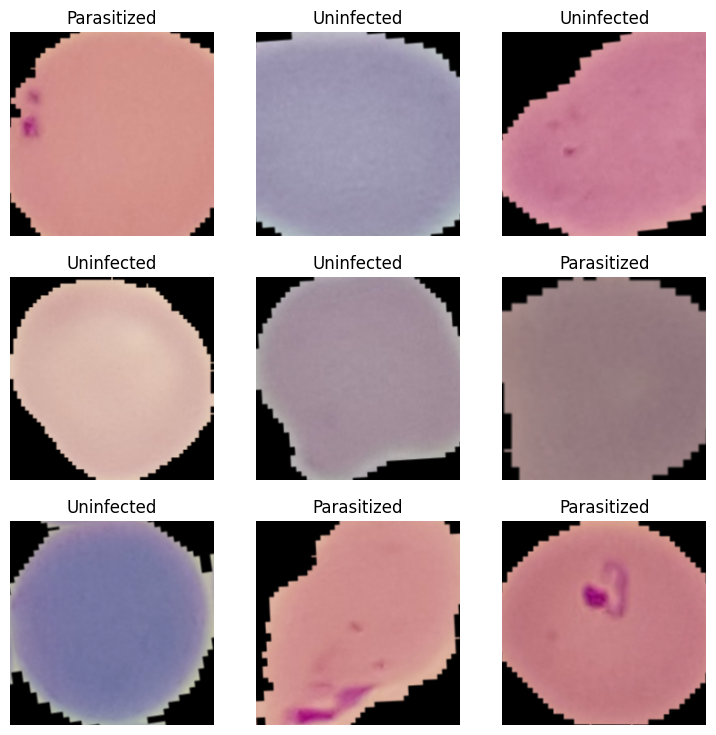

In [6]:
# Load dataset into fastai

path = Path(DATASET_DIR)

splitter = RandomSplitter(valid_pct=0.2)

item_tfms = [Resize(224)]
batch_tfms = [
    *aug_transforms(flip_vert=True, max_zoom=1.2, max_warp=0),
    Normalize.from_stats(*imagenet_stats),
]

data_block = DataBlock(
    blocks=[ImageBlock, CategoryBlock],
    get_items=get_image_files,
    get_y=parent_label,
    splitter=splitter,
    item_tfms=item_tfms,
    batch_tfms=batch_tfms,
)

data = data_block.dataloaders(path, bs=64)
data.show_batch()

In [11]:
# Load a pre-trained model
learner = cnn_learner(data, resnet18, metrics=[accuracy])
learner.fine_tune()

epoch,train_loss,valid_loss,accuracy,time
0,0.284133,0.202918,0.920523,01:35


epoch,train_loss,valid_loss,accuracy,time
0,0.165705,0.113987,0.957902,02:05
1,0.144911,0.107011,0.961894,02:05
2,0.130180,0.100335,0.964798,02:06
3,0.135773,0.096438,0.966612,02:06
4,0.125396,0.104046,0.964798,02:05
5,0.116773,0.087706,0.969878,02:06
6,0.116010,0.086876,0.971693,02:06
7,0.118712,0.083564,0.970060,02:05
8,0.103194,0.085112,0.971149,02:06
9,0.089761,0.091348,0.967157,02:05


KeyboardInterrupt: 

In [13]:
learner.save("resnet18-malaria")

Path('models/resnet18-malaria.pth')

In [18]:
from fiftyone import ViewField as F

def do_inference(learner, dl, dataset, classes, tag):
    # Perform inference
    preds, _ = learner.get_preds(ds_idx=dl.split_idx)
    preds = preds.numpy()

    # Save predictions to FiftyOne dataset
    with fo.ProgressBar() as pb:
        for filepath, scores in zip(pb(dl.items), preds):
            sample = dataset[str(filepath)]
            target = np.argmax(scores)
            sample.tags = [tag]
            sample["predictions"] = fo.Classification(
                label=classes[target],
                confidence=scores[target],
                logits=np.log(scores),
            )
            sample.save()

classes = list(data.vocab)

# Run inference on train split
# do_inference(learner, data.train, dataset, classes, "train")

# Run inference on validation split
do_inference(learner, data.valid, dataset, classes, "validation")

 100% |█████████████| 22047/22047 [35.1s elapsed, 0s remaining, 677.6 samples/s]      


 100% |███████████████| 5511/5511 [8.3s elapsed, 0s remaining, 676.7 samples/s]       


In [20]:
# Evaluate the predictions in the `predictions` field with respect to the
# labels in the `ground_truth` field
results = dataset.evaluate_classifications(
    "predictions",
    gt_field="ground_truth",
    eval_key="eval",
    method="binary",
    classes=["Uninfected", "Parasitized"],
)

results.print_report()

              precision    recall  f1-score   support

  Uninfected       0.97      0.98      0.98     13780
 Parasitized       0.98      0.97      0.98     13780

    accuracy                           0.98     27560
   macro avg       0.98      0.98      0.98     27560
weighted avg       0.98      0.98      0.98     27560



# getting to know about the models now

In [21]:
def get_model_macs(model, inputs) -> int:
    return profile_macs(model, inputs)


def get_sparsity(tensor: torch.Tensor) -> float:
    """
    calculate the sparsity of the given tensor
        sparsity = #zeros / #elements = 1 - #nonzeros / #elements
    """
    return 1 - float(tensor.count_nonzero()) / tensor.numel()


def get_model_sparsity(model: nn.Module) -> float:
    """
    calculate the sparsity of the given model
        sparsity = #zeros / #elements = 1 - #nonzeros / #elements
    """
    num_nonzeros, num_elements = 0, 0
    for param in model.parameters():
        num_nonzeros += param.count_nonzero()
        num_elements += param.numel()
    return 1 - float(num_nonzeros) / num_elements

def get_num_parameters(model: nn.Module, count_nonzero_only=False) -> int:
    """
    calculate the total number of parameters of model
    :param count_nonzero_only: only count nonzero weights
    """
    num_counted_elements = 0
    for param in model.parameters():
        if count_nonzero_only:
            num_counted_elements += param.count_nonzero()
        else:
            num_counted_elements += param.numel()
    return num_counted_elements


def get_model_size(model: nn.Module, data_width=32, count_nonzero_only=False) -> int:
    """
    calculate the model size in bits
    :param data_width: #bits per element
    :param count_nonzero_only: only count nonzero weights
    """
    return get_num_parameters(model, count_nonzero_only) * data_width

Byte = 8
KiB = 1024 * Byte
MiB = 1024 * KiB
GiB = 1024 * MiB

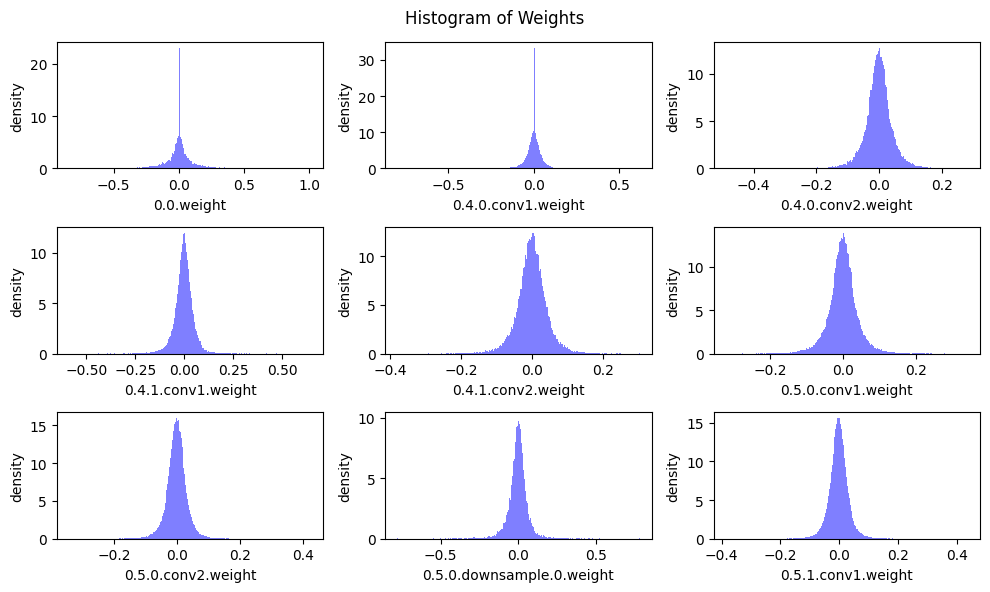

In [26]:
#Before we jump into pruning, let's see the distribution of weight values in the dense model.



def plot_weight_distribution(model, bins=256, count_nonzero_only=False):
    fig, axes = plt.subplots(3,3, figsize=(10, 6))
    axes = axes.ravel()
    plot_index = 0
    for name, param in model.named_parameters():
        if param.dim() > 1 and plot_index<9:
            ax = axes[plot_index]
            if count_nonzero_only:
                param_cpu = param.detach().view(-1).cpu()
                param_cpu = param_cpu[param_cpu != 0].view(-1)
                ax.hist(param_cpu, bins=bins, density=True,
                        color = 'blue', alpha = 0.5)
            else:
                ax.hist(param.detach().view(-1).cpu(), bins=bins, density=True,
                        color = 'blue', alpha = 0.5)
            ax.set_xlabel(name)
            ax.set_ylabel('density')
            plot_index += 1
    fig.suptitle('Histogram of Weights')
    fig.tight_layout()
    fig.subplots_adjust(top=0.925)
    plt.show()

plot_weight_distribution(learner.model)

# Fine-Grained Pruning

## Overview  
This repository provides an implementation of **Fine-Grained Pruning**, a method used to sparsify neural network weight tensors by removing synapses (connections) of lowest importance. Fine-grained pruning helps in reducing the computational complexity and memory footprint of neural networks without significantly affecting their performance.

## What is Fine-Grained Pruning?  
Fine-grained pruning selectively removes synapses by zeroing out weights with the lowest importance. The resulting weight tensor becomes sparse, which can be measured using **sparsity**:

\[
\text{sparsity} = \frac{\text{Number of zero elements in } W}{\text{Total number of elements in } W}
\]

Where \( W \) is the weight tensor of a given layer.

### Pruning Mechanism  
Given a target sparsity level \( S \), the fine-grained pruning process can be described as follows:

1. **Compute the Importance Tensor**:  
   An importance tensor \( I \) is generated for the weight tensor \( W \). The importance of each element can be determined based on criteria such as absolute magnitude.

2. **Determine the Pruning Threshold**:  
   The pruning threshold \( \theta \) is computed by finding the \( k \)-th smallest value in the importance tensor \( I \), where \( k \) corresponds to the required sparsity level.

3. **Apply Binary Mask**:  
   A binary mask \( M \) is created, where elements with importance less than the threshold are set to zero, and others are set to one. The final pruned weight tensor \( W' \) is obtained by multiplying the original weight tensor with the mask:

   \[
   W' = W \odot M
   \]

Where \( \odot \) denotes element-wise multiplication.

### Notation  
- \( W \): Original weight tensor.  
- \( I \): Importance tensor of the same shape as \( W \).  
- \( \theta \): Pruning threshold determined by the \( k \)-th smallest value of \( I \).  
- \( M \): Binary mask used to disregard pruned weights.  
- \( W' \): Pruned weight tensor after applying the binary mask.

## Implementation  
This section contains the steps to implement fine-grained pruning in Python:

### 1. Calculate the Importance Tensor  
The importance of each weight can be computed using the absolute value:

```python
importance_tensor = abs(weight_tensor)


In [27]:




def fine_grained_prune(tensor: torch.Tensor, sparsity : float) -> torch.Tensor:
    """
    magnitude-based pruning for single tensor
    :param tensor: torch.(cuda.)Tensor, weight of conv/fc layer
    :param sparsity: float, pruning sparsity
        sparsity = #zeros / #elements = 1 - #nonzeros / #elements
    :return:
        torch.(cuda.)Tensor, mask for zeros
    """
    sparsity = min(max(0.0, sparsity), 1.0)
    if sparsity == 1.0:
        tensor.zero_()
        return torch.zeros_like(tensor)
    elif sparsity == 0.0:
        return torch.ones_like(tensor)

    num_elements = tensor.numel()

    ##################### YOUR CODE STARTS HERE #####################
    # Step 1: calculate the #zeros (please use round())
    num_zeros = round(num_elements * sparsity)
    # Step 2: calculate the importance of weight
    importance = torch.abs(tensor)
    # Step 3: calculate the pruning threshold
    threshold = torch.kthvalue(importance.flatten(), num_zeros)[0]
    # Step 4: get binary mask (1 for nonzeros, 0 for zeros)
    mask = importance > threshold
    ##################### YOUR CODE ENDS HERE #######################

    # Step 5: apply mask to prune the tensor
    tensor.mul_(mask)

    return mask

In [28]:

class FineGrainedPruner:
    def __init__(self, model, sparsity_dict):
        self.masks = FineGrainedPruner.prune(model, sparsity_dict)

    @torch.no_grad()
    def apply(self, model):
        for name, param in model.named_parameters():
            if name in self.masks:
                param *= self.masks[name]

    @staticmethod
    @torch.no_grad()
    def prune(model, sparsity_dict):
        masks = dict()
        for name, param in model.named_parameters():
            if param.dim() > 1: # we only prune conv and fc weights
                masks[name] = fine_grained_prune(param, sparsity_dict[name])
        return masks